### Question 3

Question 3 - Preprocesses

In [ ]:
import numpy as np
import tensorflow
from keras.datasets import mnist
from itertools import combinations
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

[T_train, row, column] = x_train.shape
T_test = x_test.shape[0]

print(f"Train features shape: {x_train.shape}\nTrain label shape: {y_train.shape}")
print(f"Test features shape: {x_test.shape}\nTest labels shape: {y_test.shape}")

Train features shape: (60000, 28, 28)
Train label shape: (60000,)
Test features shape: (10000, 28, 28)
Test labels shape: (10000,)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

min_val = np.min(x_train)
max_val = np.max(x_train)
x_train = (x_train - min_val) / (max_val - min_val)
x_test = (x_test - min_val) / (max_val - min_val)

Question 3 - Obtaining weighs (w)

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


T_subset = 100
indexes = np.random.randint(low = 0, high = T_train, size = T_subset)
subset = x_train[indexes, :]

n_features = subset.shape[1]
w = np.zeros(n_features)
s_equal = 0.0
s_nequal = 0.0
equal = 0
nequal = 0
for f in range(n_features):
    for i in range(T_subset):
        for j in range(i+1, T_subset):
            if(y_train[i] == y_train[j]):
                s_equal = s_equal + np.exp(-((subset[i, f]-subset[j, f])**2))
                equal = equal+1
            else:
                s_nequal = s_nequal + (1 - np.exp(-((subset[i, f]-subset[j, f])**2)))
                nequal = nequal+1
    w[f] = (s_equal/equal)*(s_nequal/nequal)
    s_equal = 0
    s_nequal = 0
    equal = 0
    nequal = 0

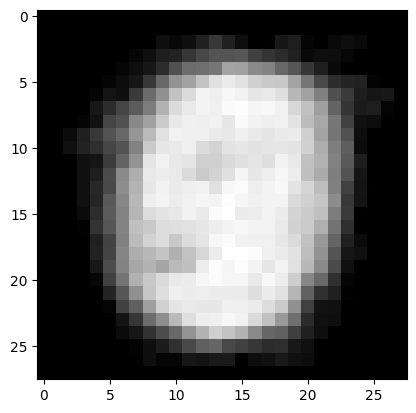

In [ ]:
plt.imshow(w.reshape(28,28), cmap='gray')
w = torch.from_numpy(w)

Question 3 - Cost function

In [ ]:
def loss_function(outputs, targets, model1, model2, w, beta):
    L_cmse = torch.mean(torch.mean(w*((outputs - targets)**2), dim=1))
    L2 = 0
    for param in model1.parameters():
        L2 += torch.sum(param**2)
    for param in model2.parameters():
        L2 += torch.sum(param**2)
    Lr = beta * L2
    return L_cmse + Lr

Question 3 - Part 1 - A (Encoder and Decoder)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_features):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(n_features, 512)
        self.relu1 = nn.ReLU()
        self.tanh1 = nn.Tanh()
        self.linear2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.tanh2 = nn.Tanh()
        self.linear3 = nn.Linear(128, 32)
        self.tanh3 = nn.Tanh()
        self.linear4 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.tanh1(self.relu1(self.linear1(x)))
        x = self.tanh2(self.relu2(self.linear2(x)))
        x = self.tanh3(self.linear3(x))
        x = self.linear4(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, n_features):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(10, 32)
        self.tanh1 = nn.Tanh()
        self.linear2 = nn.Linear(32, 128)
        self.tanh2 = nn.Tanh()
        self.linear3 = nn.Linear(128, 512)
        self.tanh3 = nn.Tanh()
        self.linear4 = nn.Linear(512, n_features)
        self.sigmoid4 = nn.Sigmoid()

    def forward(self, x):
        x = self.tanh1(self.linear1(x))
        x = self.tanh2(self.linear2(x))
        x = self.tanh3(self.linear3(x))
        x = self.sigmoid4(self.linear4(x))
        return x

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
x_train = torch.from_numpy(x_train)
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.from_numpy(x_test)
x_test = torch.tensor(x_test, dtype=torch.float32)

Question 3 - Part 1 - B (Training models)

In [ ]:
encoder = Encoder(n_features)
decoder = Decoder(n_features)

beta = 1e-9
learning_rate = 0.008
epochs = 40
batch_size = 50

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

loss_list = []
for epoch in range(epochs):
    batch_size = (int(epoch/2)+1)*50
    data_loader = data.DataLoader(dataset=x_train, batch_size=batch_size, shuffle=True)
    for i, x in enumerate(data_loader):
        out_encoder = encoder(x)
        y = decoder(out_encoder)
        loss = loss_function(y, x, encoder, decoder, w, beta)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i%34 == 0):
            print(f'Epoch {epoch+1}/{epochs} : {i+1}/{int(T_train/batch_size)}', end='\r')
    print(f"Epoch {epoch+1}/{epochs} : cost = {sum(loss_list[-batch_size:])/len(loss_list[-batch_size:])}")


Epoch 1/40 : cost = 0.0056013568632528234
Epoch 2/40 : cost = 0.0048176608564574645
Epoch 3/40 : cost = 0.004265750590273812
Epoch 4/40 : cost = 0.004107807651680644
Epoch 5/40 : cost = 0.0038583859911190932
Epoch 6/40 : cost = 0.003794047887886059
Epoch 7/40 : cost = 0.003661270248333957
Epoch 8/40 : cost = 0.003607406132446213
Epoch 9/40 : cost = 0.0035171865440374785
Epoch 10/40 : cost = 0.0034707558808782218
Epoch 11/40 : cost = 0.0034249491826330385
Epoch 12/40 : cost = 0.003376435477363514
Epoch 13/40 : cost = 0.00334251720061486
Epoch 14/40 : cost = 0.0033060606581616333
Epoch 15/40 : cost = 0.0032726231357487813
Epoch 16/40 : cost = 0.003244540951665675
Epoch 17/40 : cost = 0.003212398971570995
Epoch 18/40 : cost = 0.003188245767104592
Epoch 19/40 : cost = 0.0031706308404585992
Epoch 20/40 : cost = 0.003144557954969872
Epoch 21/40 : cost = 0.0031254729989996814
Epoch 22/40 : cost = 0.003102371875395605
Epoch 23/40 : cost = 0.0030898581559146345
Epoch 24/40 : cost = 0.0030692173

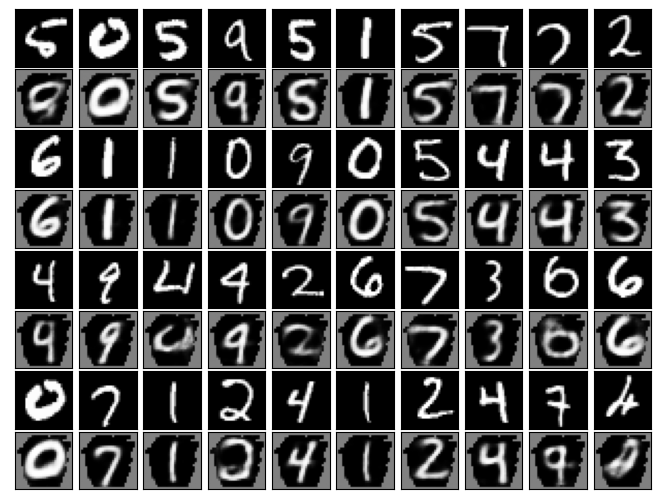

In [ ]:
from random import randint
ncols = 10
nrows = 8
fig, ax = plt.subplots(nrows, ncols)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.05, hspace=0.05)

for i in range(len(ax[0])):
    for j in range(0, nrows, 2):
        x = x_test[(i+j)*randint(0, 100)+randint(0, 10),:]
        y = decoder(encoder(x)).detach().numpy()

        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])
        ax[j][i].imshow(x.reshape(28,28), cmap='gray', vmin=0, vmax=1)

        ax[j+1][i].set_xticks([])
        ax[j+1][i].set_yticks([])
        ax[j+1][i].imshow(y.reshape(28,28), cmap='gray', vmin=0, vmax=1)

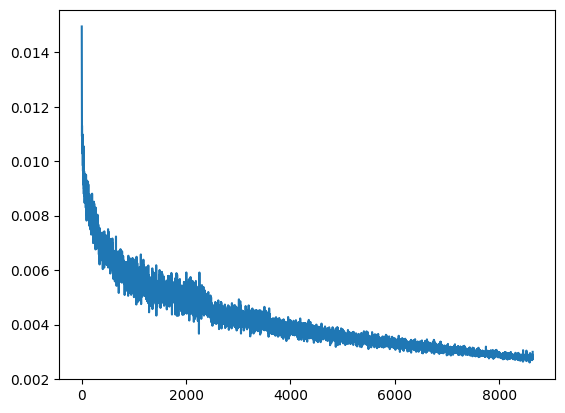

In [ ]:
plt.plot(loss_list)

Question 3 - Part 1 - C (Clustering)

In [ ]:
from sklearn.cluster import KMeans

# using kmeans on the raw x_train
kmeans_ordinary = KMeans(n_clusters=10)
kmeans_ordinary.fit(x_train.detach().numpy())

predicted_ordinary_train = kmeans_ordinary.predict(x_train.detach().numpy())
predicted_ordinary_test = kmeans_ordinary.predict(x_test.detach().numpy())

#using kmeans on the encoded x_train
x_train_encoded = encoder(x_train).detach().numpy()

x_test_encoded = encoder(x_test).detach().numpy()

kmeans_encoded = KMeans(n_clusters=10)
kmeans_encoded.fit(x_train_encoded)

predicted_encoded_train = kmeans_encoded.predict(x_train_encoded)
predicted_encoded_test = kmeans_encoded.predict(x_test_encoded)

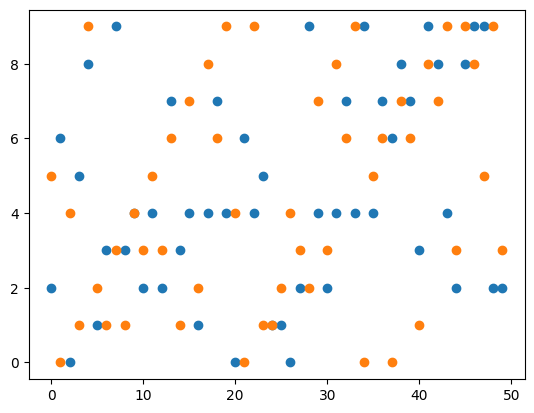

In [ ]:
plt.scatter(np.array(range(len(predicted_encoded_train[0:50]))), predicted_encoded_train[0:50])
plt.scatter(np.array(range(len(y_train[0:50]))), y_train[0:50])

In [ ]:
from sklearn.metrics import adjusted_rand_score

ari_ordinary_train = adjusted_rand_score(y_train, predicted_ordinary_train)
ari_ordinary_test = adjusted_rand_score(y_test, predicted_ordinary_test)
ari_encoded_train = adjusted_rand_score(y_train, predicted_encoded_train)
ari_encoded_test = adjusted_rand_score(y_test, predicted_encoded_test)

print(f"ARI for ordinary train: {ari_ordinary_train}")
print(f"ARI for ordinary test: {ari_ordinary_test}")
print(f"ARI for encoded train: {ari_encoded_train}")
print(f"ARI for encoded test: {ari_encoded_test}")

ARI for ordinary train: 0.36065812062604624
ARI for ordinary test: 0.36626426783515814
ARI for encoded train: 0.4623127568307444
ARI for encoded test: 0.4677684761795095
